=========================================
Background 
=========================================

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return 
back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return 
back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of 
over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, 
environmental and health issues. 

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by
these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration
of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into
a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important
events in the city could be detected via monitoring these data.

=========================================
Data Set
=========================================
Bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions,
precipitation, day of week, season, hour of the day, etc. can affect the rental behaviors. The core data set is related to  
the two-year historical log corresponding to years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA which is 
publicly available in http://capitalbikeshare.com/system-data. We aggregated the data on two hourly and daily basis and then 
extracted and added the corresponding weather and seasonal information. Weather information are extracted from http://www.freemeteo.com. 

=========================================
Associated tasks
=========================================

	- Regression: 
		Predication of bike rental count hourly or daily based on the environmental and seasonal settings.
	
	- Event and Anomaly Detection:  
		Count of rented bikes are also correlated to some events in the town which easily are traceable via search engines.
		For instance, query like "2012-10-30 washington d.c." in Google returns related results to Hurricane Sandy. Some of the important events are 
		identified in [1]. Therefore the data can be used for validation of anomaly or event detection algorithms as well.


=========================================
Files
=========================================

	- Readme.txt
	- hour.csv : bike sharing counts aggregated on hourly basis. Records: 17379 hours
	- day.csv - bike sharing counts aggregated on daily basis. Records: 731 days

	
=========================================
Dataset characteristics
=========================================	
Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv
	
	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered
	
=========================================

In [1]:
from sklearn.model_selection import train_test_split
import sklearn as sks
import statsmodels.api as sm
from statsmodels.api import add_constant
from statsmodels.api import regression
from sklearn.preprocessing import MinMaxScaler

In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vf
from sklearn.metrics import r2_score

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv("./day.csv")

In [6]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [7]:
correlation_col = [col for col in list(df.columns) if col !="dteday"]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


<Axes: >

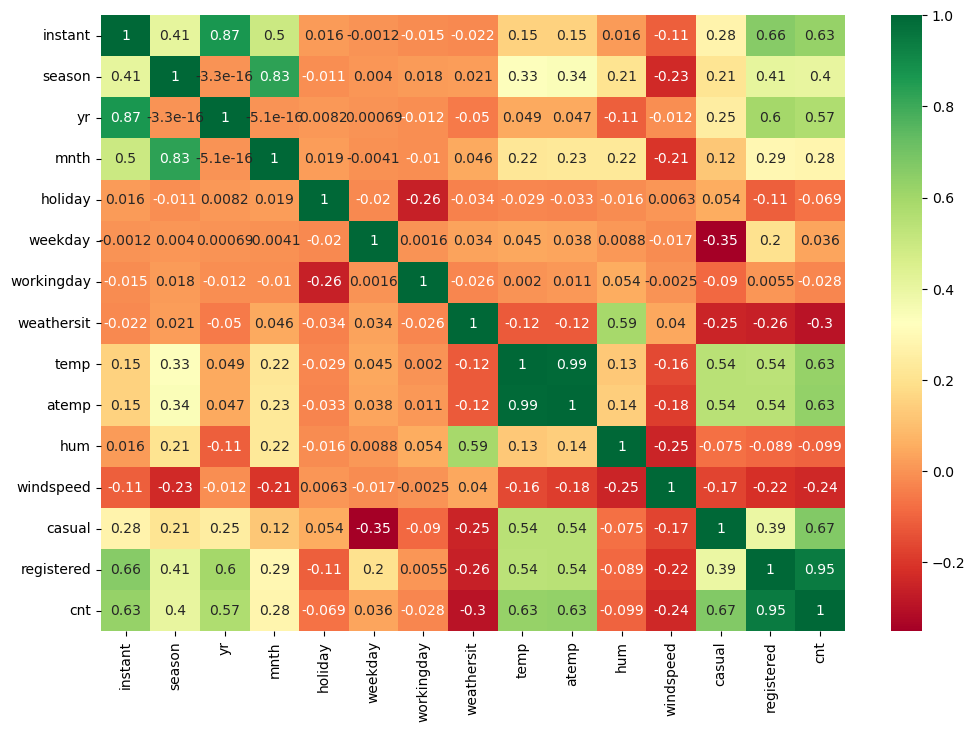

In [9]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot= True, cmap= "RdYlGn")

Inference

1- Instant, temp, atemp, casual, registered has good coorelation with cnt of bikes


2- Windspeed, weather has good negative correlation with the cnt of bikes

In [10]:
# season : season (1:springer, 2:summer, 3:fall, 4:winter)
	# + weathersit : 
	# 	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	# 	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	# 	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	# 	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog


In [11]:
df.season.unique()

array([1, 2, 3, 4])

In [12]:
seaon_dict = {1:"springer", 2:"summer", 3:"fall", 4:"winter"}
weathersit_dict = {1: "Clear, Few clouds, Partly cloudy, Partly cloudy"
	, 2: "Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist"
, 3: "Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds"
, 4: "Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog"}

In [13]:
df.season = df.season.apply(lambda x: seaon_dict[x])
df.weathersit = df.weathersit.apply(lambda x: weathersit_dict[x])

In [14]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,springer,0,1,0,1,1,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,springer,0,1,0,2,1,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,springer,0,1,0,3,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,springer,0,1,0,4,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,springer,0,1,0,5,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [15]:
df[df.workingday==0].weekday.value_counts()

6    104
0    104
3     11
2      5
4      1
5      1
Name: weekday, dtype: int64

In [16]:
weekday_dict = {0:"Sunday", 1:"Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday"}

In [17]:
df.weekday = df.weekday.apply(lambda x: weekday_dict[x])

In [18]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,springer,0,1,0,Monday,1,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,springer,0,1,0,Tuesday,1,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,springer,0,1,0,Wednesday,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,springer,0,1,0,Thursday,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,springer,0,1,0,Friday,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [19]:
df.isna().sum()/df.shape[0]

instant       0.0
dteday        0.0
season        0.0
yr            0.0
mnth          0.0
holiday       0.0
weekday       0.0
workingday    0.0
weathersit    0.0
temp          0.0
atemp         0.0
hum           0.0
windspeed     0.0
casual        0.0
registered    0.0
cnt           0.0
dtype: float64

In [20]:
columns = ["weekday", "weathersit", "season"]
for item in columns:
    temp = pd.get_dummies(df[item], drop_first= True)
    df.drop(columns=item, inplace=True)
    df = pd.concat([df, temp], axis = 1)
    

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 24 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   instant                                                                                  730 non-null    int64  
 1   dteday                                                                                   730 non-null    object 
 2   yr                                                                                       730 non-null    int64  
 3   mnth                                                                                     730 non-null    int64  
 4   holiday                                                                                  730 non-null    int64  
 5   workingday                                                      

<Axes: >

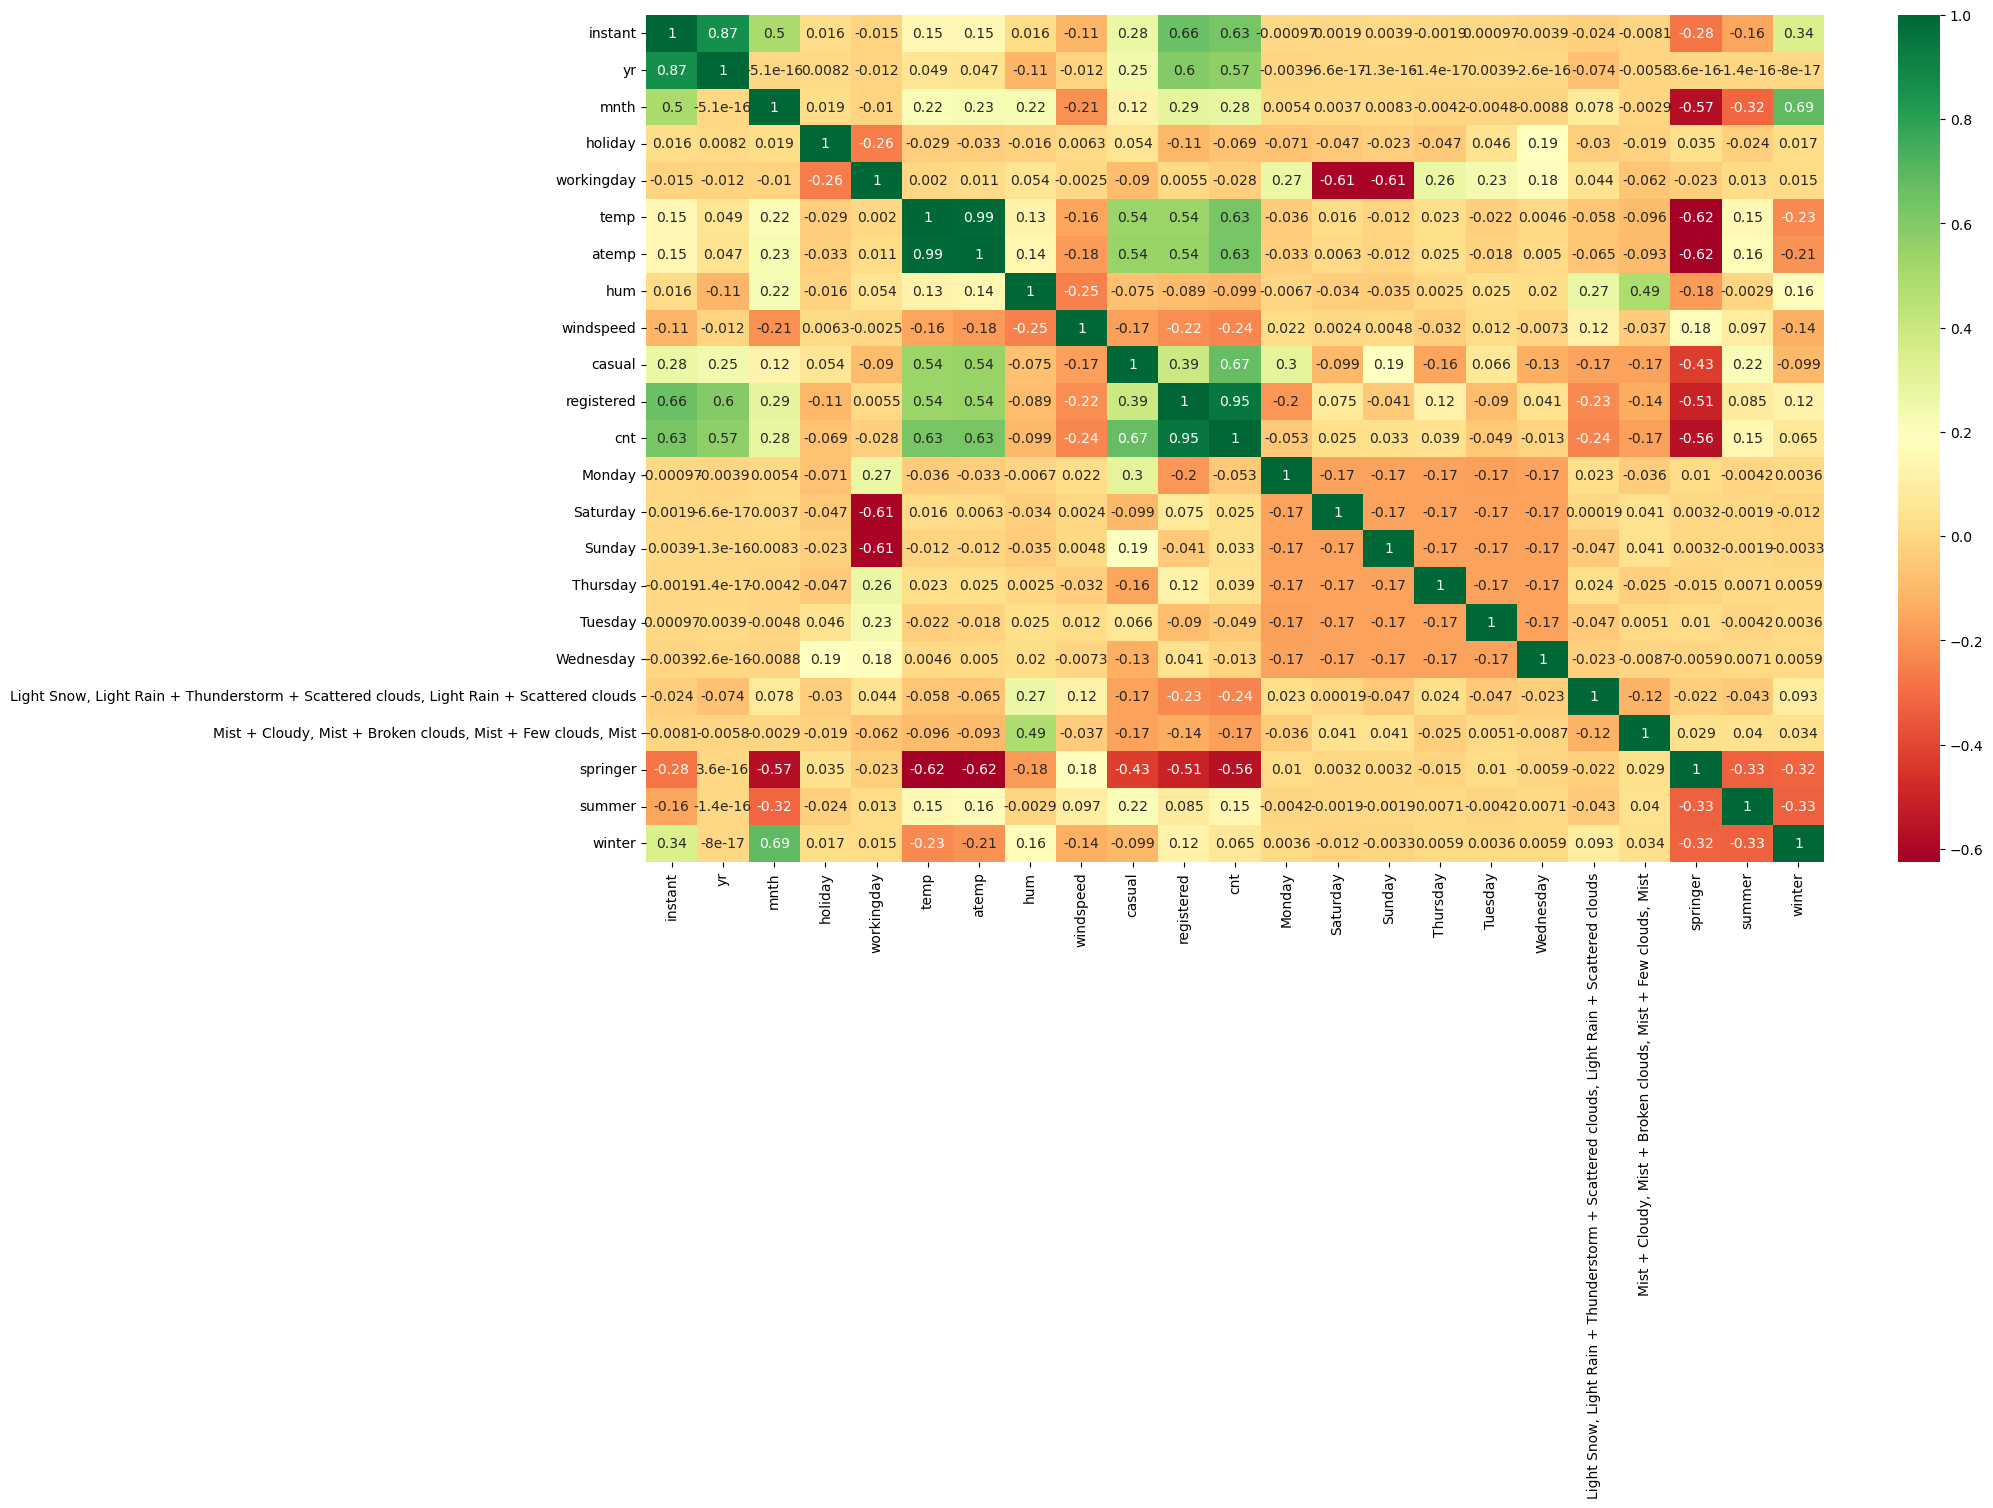

In [22]:
plt.figure(figsize=(19,11))
sns.heatmap(df.corr(), annot= True, cmap= "RdYlGn")

In [23]:
df.head(5)

,instant,dteday,yr,mnth,holiday,workingday,temp,atemp,hum,windspeed,...,Saturday,Sunday,Thursday,Tuesday,Wednesday,"Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds","Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",springer,summer,winter
0,1,01-01-2018,0,1,0,1,14.110847,18.18125,80.5833,10.749882,...,0,0,0,0,0,0,1,1,0,0
1,2,02-01-2018,0,1,0,1,14.902598,17.68695,69.6087,16.652113,...,0,0,0,1,0,0,1,1,0,0
2,3,03-01-2018,0,1,0,1,8.050924,9.47025,43.7273,16.636703,...,0,0,0,0,1,0,0,1,0,0
3,4,04-01-2018,0,1,0,1,8.200000,10.60610,59.0435,10.739832,...,0,0,1,0,0,0,0,1,0,0
4,5,05-01-2018,0,1,0,1,9.305237,11.46350,43.6957,12.522300,...,0,0,0,0,0,0,0,1,0,0


In [24]:
df.drop(columns= ["dteday"], inplace= True )

In [25]:
df.head(5)

,instant,yr,mnth,holiday,workingday,temp,atemp,hum,windspeed,casual,...,Saturday,Sunday,Thursday,Tuesday,Wednesday,"Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds","Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",springer,summer,winter
0,1,0,1,0,1,14.110847,18.18125,80.5833,10.749882,331,...,0,0,0,0,0,0,1,1,0,0
1,2,0,1,0,1,14.902598,17.68695,69.6087,16.652113,131,...,0,0,0,1,0,0,1,1,0,0
2,3,0,1,0,1,8.050924,9.47025,43.7273,16.636703,120,...,0,0,0,0,1,0,0,1,0,0
3,4,0,1,0,1,8.200000,10.60610,59.0435,10.739832,108,...,0,0,1,0,0,0,0,1,0,0
4,5,0,1,0,1,9.305237,11.46350,43.6957,12.522300,82,...,0,0,0,0,0,0,0,1,0,0


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 23 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   instant                                                                                  730 non-null    int64  
 1   yr                                                                                       730 non-null    int64  
 2   mnth                                                                                     730 non-null    int64  
 3   holiday                                                                                  730 non-null    int64  
 4   workingday                                                                               730 non-null    int64  
 5   temp                                                            

In [27]:
df.columns

Index(['instant', 'yr', 'mnth', 'holiday', 'workingday', 'temp', 'atemp',
       'hum', 'windspeed', 'casual', 'registered', 'cnt', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
       'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
       'springer', 'summer', 'winter'],
      dtype='object')

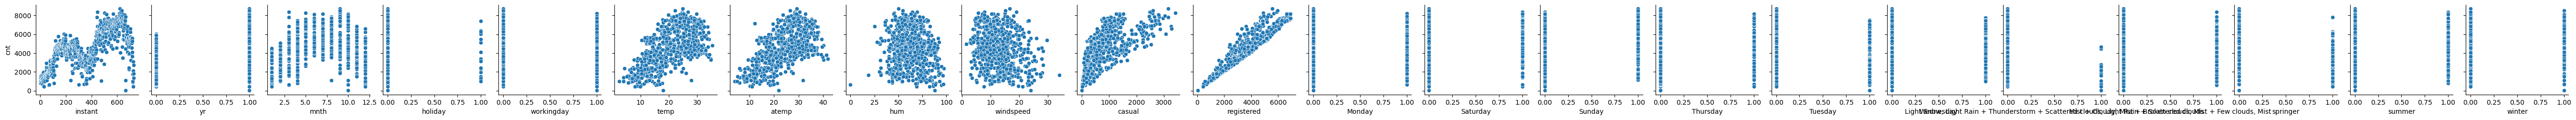

In [28]:
sns.pairplot(x_vars= ['instant', 'yr', 'mnth', 'holiday', 'workingday', 'temp', 'atemp',
       'hum', 'windspeed', 'casual', 'registered', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
       'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
       'springer', 'summer', 'winter'], y_vars= "cnt", data = df)

In [29]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=100)

In [30]:
print(df_train.shape, df_test.shape)

(584, 23) (146, 23)


In [31]:
scaler = MinMaxScaler()

In [32]:
col = ['instant', 'mnth', 'temp', 'atemp',
       'hum', 'windspeed', 'casual', 'registered']

df[col].describe()

,instant,mnth,temp,atemp,hum,windspeed,casual,registered
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,6.526027,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534
std,210.877136,3.450215,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728
min,1.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000
25%,183.250000,4.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000
50%,365.500000,7.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000
75%,547.750000,10.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000
max,730.000000,12.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000


In [33]:
df_train[col] = scaler.fit_transform(df_train[col])

In [34]:
scaler

MinMaxScaler()

In [35]:
y_train = df_train.pop("cnt")
X_train = df_train
X_train_sm = add_constant(X_train)

In [36]:
lr = sm.OLS(y_train, X_train_sm)
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.213e+30
Date:                Sun, 28 Jul 2024   Prob (F-statistic):               0.00
Time:                        17:53:37   Log-Likelihood:                 14311.
No. Observations:                 584   AIC:                        -2.858e+04
Df Residuals:                     561   BIC:                        -2.848e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================================================
                                                                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                      22.0000   5.08e-12   4.33e+12      0.000      22.000      22.000
instant                                                                                 -2.547e-11   1.91e-11     -1.333      0.183    -6.3e-11    1.21e-11
yr                                                                                       1.182e-11   9.62e-12      1.229      0.220   -7.08e-12    3.07e-11
mnth                                                                                     1.091e-11   8.92e-12      1.224      0.222    -6.6e-12    2.84e-11
holiday                                                                                 -1.648e-12   4.08e-12     -0.404      0.686   -9.66e-12    6.36e-12
workingday                                                                               3.979e-12   4.36e-12      0.912      0.362   -4.59e-12    1.26e-11
temp                                                                                     9.095e-13   8.35e-12      0.109      0.913   -1.55e-11    1.73e-11
atemp                                                                                   -1.819e-12    8.5e-12     -0.214      0.831   -1.85e-11    1.49e-11
hum                                                                                      4.547e-13   2.28e-12      0.200      0.842   -4.02e-12    4.93e-12
windspeed                                                                               -3.865e-12   1.61e-12     -2.404      0.017   -7.02e-12   -7.07e-13
casual                                                                                   3281.0000   1.89e-12   1.74e+15      0.000    3281.000    3281.000
registered                                                                               6926.0000   2.45e-12   2.83e+15      0.000    6926.000    6926.000
Monday                                                                                   1.279e-13   1.05e-12      0.122      0.903   -1.93e-12    2.19e-12
Saturday                                                                                -1.137e-12   4.39e-12     -0.259      0.796   -9.77e-12     7.5e-12
Sunday                                                                                  -2.046e-12    4.4e-12     -0.466      0.642   -1.07e-11    6.59e-12
Thursday                                                                                 1.251e-12   8.57e-13      1.458      0.145   -4.34e-13    2.93e-12
Tuesday                                                                                  1.364e-12   8.98e-13      1.51

In [37]:
vif = pd.DataFrame()
vif["features"] = X_train_sm.columns
vif["variance"] = [vf(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif.sort_values("variance", ascending= False)

,features,variance
1,instant,565.471166
0,const,477.005470
2,yr,427.079716
3,mnth,146.445813
5,workingday,69.933279
6,temp,65.291035
7,atemp,59.650059
14,Sunday,40.378859
13,Saturday,37.616405
4,holiday,8.179799


In [38]:
col_to_choose = X_train.columns

In [39]:
col_to_choose = ['instant', 'yr', 'mnth', 'holiday', 'workingday', 'atemp',
       'hum', 'windspeed', 'casual', 'registered', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
       'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
       'springer', 'summer', 'winter']

In [40]:
X_train = X_train[col_to_choose]
X_train_sm = add_constant(X_train)
lr = sm.OLS(y_train, X_train_sm)
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.111e+29
Date:                Sun, 28 Jul 2024   Prob (F-statistic):               0.00
Time:                        17:53:38   Log-Likelihood:                 13812.
No. Observations:                 584   AIC:                        -2.758e+04
Df Residuals:                     562   BIC:                        -2.748e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================================================
                                                                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                      22.0000   1.19e-11   1.85e+12      0.000      22.000      22.000
instant                                                                                 -1.819e-12   4.48e-11     -0.041      0.968   -8.98e-11    8.62e-11
yr                                                                                       8.185e-12   2.26e-11      0.363      0.717   -3.61e-11    5.25e-11
mnth                                                                                    -5.457e-12   2.09e-11     -0.261      0.794   -4.65e-11    3.56e-11
holiday                                                                                 -1.592e-12   9.57e-12     -0.166      0.868   -2.04e-11    1.72e-11
workingday                                                                              -1.592e-12   1.02e-11     -0.155      0.877   -2.17e-11    1.85e-11
atemp                                                                                     4.15e-12   5.58e-12      0.744      0.457    -6.8e-12    1.51e-11
hum                                                                                      7.731e-12   5.35e-12      1.446      0.149   -2.77e-12    1.82e-11
windspeed                                                                                5.684e-13   3.68e-12      0.155      0.877   -6.65e-12    7.79e-12
casual                                                                                   3281.0000   4.39e-12   7.47e+14      0.000    3281.000    3281.000
registered                                                                               6926.0000   5.73e-12   1.21e+15      0.000    6926.000    6926.000
Monday                                                                                   5.869e-12   2.46e-12      2.384      0.017    1.03e-12    1.07e-11
Saturday                                                                                -5.912e-12   1.03e-11     -0.573      0.567   -2.62e-11    1.43e-11
Sunday                                                                                  -4.889e-12   1.03e-11     -0.474      0.636   -2.52e-11    1.54e-11
Thursday                                                                                 1.421e-12   2.01e-12      0.706      0.480   -2.53e-12    5.37e-12
Tuesday                                                                                  3.809e-12   2.11e-12      1.807      0.071   -3.32e-13    7.95e-12
Wednesday                                                                                3.411e-13   2.08e-12      0.16

In [41]:
vif = pd.DataFrame()
vif["features"] = X_train_sm.columns
vif["variance"] = [vf(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif.sort_values("variance", ascending= False)

,features,variance
1,instant,564.391286
0,const,475.927358
2,yr,426.102934
3,mnth,146.184348
5,workingday,69.932637
13,Sunday,40.372744
12,Saturday,37.613713
4,holiday,8.178344
10,registered,5.822580
19,springer,5.606497


In [42]:
from sklearn.linear_model import LinearRegression

In [43]:
from sklearn.feature_selection import RFE
# from sklearn.svm import SVR
# from sklearn.datasets import fetch_california_housing
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=12)
selector.fit(X_train, y_train)
print(selector.support_)
#


[ True  True  True  True False  True  True  True  True  True  True False
 False False False False False False  True  True False]


In [44]:
tru_val = selector.support_

In [45]:
all_col = X_train.columns

In [46]:
col_to_choose = [all_col[i] for i in range(len(all_col)) if tru_val[i]==True ]

In [47]:
col_to_choose

['instant',
 'yr',
 'mnth',
 'holiday',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered',
 'Monday',
 'springer',
 'summer']

In [48]:
X_train = X_train[col_to_choose]
X_train_sm = add_constant(X_train)
lr = sm.OLS(y_train, X_train_sm)
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.380e+29
Date:                Sun, 28 Jul 2024   Prob (F-statistic):               0.00
Time:                        17:53:38   Log-Likelihood:                 13657.
No. Observations:                 584   AIC:                        -2.729e+04
Df Residuals:                     571   BIC:                        -2.723e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.0000   6.83e-12   3.22e+12      0.000      22.000      22.000
instant    -2.365e-11   5.76e-11     -0.411      0.681   -1.37e-10    8.95e-11
yr          1.819e-11   2.89e-11      0.628      0.530   -3.87e-11     7.5e-11
mnth        1.637e-11   2.68e-11      0.610      0.542   -3.63e-11     6.9e-11
holiday    -2.387e-12   4.51e-12     -0.529      0.597   -1.12e-11    6.47e-12
atemp        1.99e-12   5.66e-12      0.351      0.726   -9.14e-12    1.31e-11
hum         2.728e-12   5.66e-12      0.482      0.630   -8.39e-12    1.38e-11
windspeed  -1.023e-12   4.72e-12     -0.217      0.829   -1.03e-11    8.25e-12
casual      3281.0000   4.99e-12   6.57e+14      0.000    3281.000    3281.000
registered  6926.0000    6.4e-12   1.08e+15      0.000    6926.000    6926.000
Monday      9.024e-13   2.32e-12      0.389      0.698   -3.66e-12    5.46e-12
springer   -3.411e-13   3.48e-12     -0.098      0.922   -7.18e-12     6.5e-12
summer      9.095e-13    2.4e-12      0.379      0.705    -3.8e-12    5.62e-12
==============================================================================
Omnibus:                       48.391   Durbin-Watson:                   0.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.368
Skew:                           0.234   Prob(JB):                     3.78e-05
Kurtosis:                       2.214   Cond. No.                         175.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
vif = pd.DataFrame()
vif["features"] = X_train_sm.columns
vif["variance"] = [vf(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif.sort_values("variance", ascending= False)

,features,variance
1,instant,556.328616
2,yr,418.394850
3,mnth,143.440156
0,const,93.217273
11,springer,4.569712
9,registered,4.344099
5,atemp,2.868518
12,summer,2.139484
8,casual,2.101845
10,Monday,1.418799


In [50]:
col_to_choose

['instant',
 'yr',
 'mnth',
 'holiday',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered',
 'Monday',
 'springer',
 'summer']

In [52]:
col_to_choose = [ 'holiday',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered',
 'Monday',
 'springer',
 'summer']

In [53]:
X_train = X_train[col_to_choose]
X_train_sm = add_constant(X_train)
lr = sm.OLS(y_train, X_train_sm)
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.988e+29
Date:                Sun, 28 Jul 2024   Prob (F-statistic):               0.00
Time:                        17:54:02   Log-Likelihood:                 13434.
No. Observations:                 584   AIC:                        -2.685e+04
Df Residuals:                     574   BIC:                        -2.680e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.0000    8.4e-12   2.62e+12      0.000      22.000      22.000
holiday    -3.638e-12   6.49e-12     -0.561      0.575   -1.64e-11     9.1e-12
atemp        2.53e-12   7.47e-12      0.339      0.735   -1.21e-11    1.72e-11
hum         1.046e-11      8e-12      1.307      0.192   -5.25e-12    2.62e-11
windspeed  -6.935e-12   6.74e-12     -1.029      0.304   -2.02e-11     6.3e-12
casual      3281.0000   7.16e-12   4.58e+14      0.000    3281.000    3281.000
registered  6926.0000   6.26e-12   1.11e+15      0.000    6926.000    6926.000
Monday      2.743e-12   3.34e-12      0.822      0.412   -3.81e-12     9.3e-12
springer    5.542e-13   3.44e-12      0.161      0.872   -6.21e-12    7.32e-12
summer      4.775e-12   2.64e-12      1.809      0.071   -4.08e-13    9.96e-12
==============================================================================
Omnibus:                       12.040   Durbin-Watson:                   0.045
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.245
Skew:                           0.350   Prob(JB):                      0.00219
Kurtosis:                       3.111   Cond. No.                         17.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
vif = pd.DataFrame()
vif["features"] = X_train_sm.columns
vif["variance"] = [vf(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif.sort_values("variance", ascending= False)

,features,variance
0,const,66.166229
2,atemp,2.340337
8,springer,2.092401
5,casual,2.029728
6,registered,1.942979
7,Monday,1.373782
3,hum,1.245400
9,summer,1.212340
4,windspeed,1.200809
1,holiday,1.050569


In [57]:
col

['instant',
 'mnth',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered']

In [58]:
df_test[col] = scaler.transform(df_test[col])

In [59]:
y_test_actual = df_test.pop("cnt")

In [60]:
X_test = df_test

In [62]:
X_test_sm = add_constant(X_test[col_to_choose])

In [63]:
lr_model.predict(X_test_sm)

184    6043.0
535    6211.0
299    2659.0
221    4780.0
152    4968.0
        ...  
219    4326.0
719    3623.0
3      1562.0
392    4023.0
360    1162.0
Length: 146, dtype: float64

In [64]:
# RMSE, MSE, error plots

SyntaxError: invalid syntax (1040280935.py, line 1)